# Example on how the model can be run

## Run notebook from project root

Adjust `path_to_top_dir = "../../"`

In [1]:
import sys
import os

path_to_top_dir = "../../"
sys.path.append(os.path.abspath(path_to_top_dir))

In [2]:
root_path = os.path.abspath(path_to_top_dir)
root_path

'c:\\Users\\paulj\\Desktop\\Master'

In [3]:
os.getcwd()

'c:\\Users\\paulj\\Desktop\\Master\\trials\\example'

## Imports

In [4]:
import pathlib
from torch_scatter import scatter
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem.Draw import MolsToGridImage, MolToImage
from tensorboard.backend.event_processing import event_accumulator
import sqlite3
import numpy as np
from rdkit import Chem
import shutil
from omegaconf import OmegaConf
from collections import defaultdict

In [5]:
from src.submodels.gflownet.config import Config,init_empty
import torch
import gc
from src.model.scent_trainer import ScentTrainer

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.



############################################################
#                     Initialize MCFs                      #
############################################################

Filter                                        Min        Max
------------------------------------------------------------
LogP                                         0.06       4.91
Molecular Weight                           100.12     282.46
HBAB + HBD                                   0.00       5.00
TPSA                                         0.00      63.32
Rotatable Bonds                              0.00      11.00
NO2 Groups                                   0.00       0.00
Heteroatoms                                  0.00       4.00
Aromatic Rings                               0.00       1.00
Atom Count                                   0.00      20.00
Triple Bonds                                 0.00       0.00
Oxygen Chain Length                          0.00       1.00

#####################

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Configure

Best hyperparameters

In [6]:
best_params = {
    # Fixed
    'algo_variant': 1, 
    'opt_momentum': 0.651294024078677,
    'opt_weight_decay': 3.9731330248837407e-07,

    # Learned
    'algo_sampling_tau': 0.9840271666819398,
    'algo_Z_learning_rate': 3.157262808970358e-05,
    'opt_learning_rate': 0.0002566028526773609,
    'opt_clip_grad_param': 32.27804232610293
    }

Configuration

In [7]:

config = init_empty(Config())

# For CPU
config.device = torch.device('cpu')
config.num_workers = 0
config.log_dir =os.path.join(root_path, "logs/example_glownet/")
config.overwrite_existing_exp=False

config.validate_every=1000
config.algo.num_from_policy = 32
config.algo.num_from_dataset = 32
config.algo.valid_num_from_policy= 32
config.algo.valid_num_from_dataset= 32
config.num_training_steps = 10 #10_000
config.print_every =1
config.seed = 1


config.algo.tb.do_parameterize_p_b = False # Dont know how to load the model with this parameter = True
config.num_validation_gen_steps = 1
#config.overwrite_existing_exp=True
config.algo.tb.mask_invalid_rewards = False
config.algo.tb.std_cut_losses = False
config.algo.tb.std_cut_scale = 1


# OPTUNA PARAMETERS
# Algo
config.algo.tb.variant = best_params["algo_variant"]
config.algo.sampling_tau = best_params["algo_sampling_tau"]
config.algo.tb.Z_learning_rate = best_params["algo_Z_learning_rate"]
# Opt
config.opt.clip_grad_param = best_params["opt_clip_grad_param"]
config.opt.momentum = best_params["opt_momentum"]
config.opt.learning_rate = best_params["opt_learning_rate"]
config.opt.weight_decay = best_params["opt_weight_decay"]

## Train

In [8]:
gc.collect()
trainer = ScentTrainer(config, print_config=True)


trainer.run()
gc.collect()



Hyperparameters:

desc: noDesc
log_dir: c:\Users\paulj\Desktop\Master\logs/example_glownet/
device: cpu
seed: 1
validate_every: 1000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 10
num_workers: 0
hostname: LAPTOP-JIE0TNQT
pickle_mp_messages: false
git_hash: a597ac3
overwrite_existing_exp: false
algo:
  method: TB
  num_from_policy: 32
  num_from_dataset: 32
  valid_num_from_policy: 32
  valid_num_from_dataset: 32
  max_len: 128
  max_nodes: 20
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.001
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9840271666819398
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: SubTB1
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb

41162

## Save

In [9]:
def save_run(trial):
    state = {
        "models_state_dict": [trial.model.state_dict()],
        "cfg": trial.cfg,
        "env_ctx": trial.model.env_ctx,
        #"model": trial.model,
    }
    if trial.sampling_model is not trial.model:
        state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
    fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
    with open(fn, "wb") as fd:
        torch.save(
            state,
            fd,
        )

In [10]:
save_run(trainer)

## Validate

### Run validation

Create validation trainer

In [19]:
batch_idx = trainer.cfg.num_training_steps % max(len(trainer.training_data),1)
epoch_idx = trainer.cfg.num_training_steps // max(len(trainer.training_data),1)
batch_idx,epoch_idx

(10, 0)

In [20]:
validation_config = copy.deepcopy(config)
validation_config.algo.valid_num_from_policy= 0
validation_config.algo.valid_num_from_dataset= 1
validation_config.log_dir = config.log_dir[:-1] + "_validation"
validation_trainer = ScentTrainer(validation_config, print_config=False)
validation_trainer.model = copy.deepcopy(trainer.model)
validation_trainer.sampling_model = copy.deepcopy(trainer.model)
validation_trainer.training_data = copy.deepcopy(trainer.training_data)
validation_trainer.test_data = copy.deepcopy(trainer.test_data)

In [21]:
n_drawn = validation_trainer.cfg.algo.valid_num_from_policy
n_from_dataset = validation_trainer.cfg.algo.valid_num_from_dataset
n_drawn,n_from_dataset

(0, 1)

Iterate through the whole test set an log rewards, forward and backward probabilities. 

In [22]:
valid_dl = validation_trainer.build_validation_data_loader()
df = trainer.test_data.df.iloc[validation_trainer.test_data.idcs]
#valid_df = pd.DataFrame()
rows = []



for batch, smiles in zip(valid_dl, df["nonStereoSMILES"]):
    info = validation_trainer.evaluate_batch(batch.to(validation_trainer.device), epoch_idx, batch_idx)
    batch_idx_ = torch.arange(n_from_dataset, device=validation_trainer.device).repeat_interleave(batch.traj_lens)
    cond_info = getattr(batch, "cond_info", None)
    batched_cond_info = cond_info[batch_idx_] if cond_info is not None else None
    fwd_cat, per_graph_out = validation_trainer.model(batch, batched_cond_info)
    log_pF = fwd_cat.log_prob(batch.actions)
    traj_log_p_F = scatter(log_pF, batch_idx_, dim=0, dim_size=n_from_dataset, reduce="sum")
    log_p_B = batch.log_p_B
    traj_log_p_B = scatter(log_p_B, batch_idx_, dim=0, dim_size=n_from_dataset, reduce="sum")
    log_rewards = batch.log_rewards

    row = {
        'SMILES': smiles,
        'traj_p_F': traj_log_p_F.exp().item(),  
        'traj_p_B': traj_log_p_B.exp().item(),
        'reward': log_rewards.exp().item()
    }
    row = { **row, **info}
    rows.append(row)
    
    print(f"{smiles:<40} traj_p_F:{traj_log_p_F.exp().item():.5f} traj_p_B:{traj_log_p_B.exp().item():.5f} reward:{log_rewards.exp().item():.2f}" + " ".join(f"{k}:{v:.2f}" for k, v in info.items()))
    gc.collect()
valid_df = pd.DataFrame(rows)

CCCCCC(=O)OCCc1ccccc1                    traj_p_F:0.00000 traj_p_B:0.00000 reward:0.79offline_loss:319.68 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-8.24 loss:319.68 n_loss:0.00 tb_loss:319.68 batch_entropy:73.07 traj_lens:22.00 eval_time:0.07
CC1=CCC(=C(C)C)CC1                       traj_p_F:0.00000 traj_p_B:0.00000 reward:0.69offline_loss:175.05 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-8.24 loss:175.05 n_loss:0.00 tb_loss:175.05 batch_entropy:44.75 traj_lens:14.00 eval_time:0.04
CC1=C(O)C(=O)C(C)C1C                     traj_p_F:0.00000 traj_p_B:0.00000 reward:0.83offline_loss:151.39 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-8.24 loss:151.39 n_loss:0.00 tb_loss:151.39 batch_entropy:43.56 traj_lens:14.00 eval_time:0.05
CCCCCCCCCC

In [23]:
valid_df.to_csv(os.path.join(config.log_dir, "example_validation.csv"),index=None)
valid_df.head()

,SMILES,traj_p_F,traj_p_B,reward,offline_loss,online_loss,reward_loss,invalid_trajectories,invalid_logprob,invalid_losses,backward_vs_unif,logZ,loss,n_loss,tb_loss,batch_entropy,traj_lens,eval_time
0,CCCCCC(=O)OCCc1ccccc1,1.847141e-32,7.752277e-12,0.789376,319.682373,0,0,0,0.0,0.0,0.0,-8.24124,319.682373,0.0,319.682373,73.069084,22.0,0.074165
1,CC1=CCC(=C(C)C)CC1,3.686499e-20,5.023476e-08,0.689498,175.052673,0,0,0,0.0,0.0,0.0,-8.24124,175.052673,0.0,175.052673,44.747025,14.0,0.041183
2,CC1=C(O)C(=O)C(C)C1C,1.210288e-19,6.028171e-08,0.830900,151.390289,0,0,0,0.0,0.0,0.0,-8.24124,151.390289,0.0,151.390289,43.558258,14.0,0.052203
3,CCCCCCCCCCCC(OC)OC,1.971272e-25,1.786125e-06,0.597757,346.453796,0,0,0,0.0,0.0,0.0,-8.24124,346.453796,0.0,346.453796,56.885948,17.0,0.055020
4,N#CC=Cc1ccccc1,1.388614e-26,6.357831e-08,0.904247,362.426483,0,0,0,0.0,0.0,0.0,-8.24124,362.426483,0.0,362.426483,59.538906,17.0,0.056151


**Validation metrics**

In [24]:
valid_df[["reward","loss"]].mean()

reward      0.697542
loss      633.095911
dtype: float64

In [25]:
valid_df[["reward","loss"]].median()

reward      0.671449
loss      214.469345
dtype: float64

In [26]:
valid_df[["reward","loss"]].max()

reward        0.996399
loss      70340.703125
dtype: float64

In [27]:
valid_df[["reward","loss"]].min()

reward      0.303542
loss      104.641815
dtype: float64

### Visualize validation

Trajectory probability $p_F(\tau)$ vs. reward R(x). High rewards should have a high probability

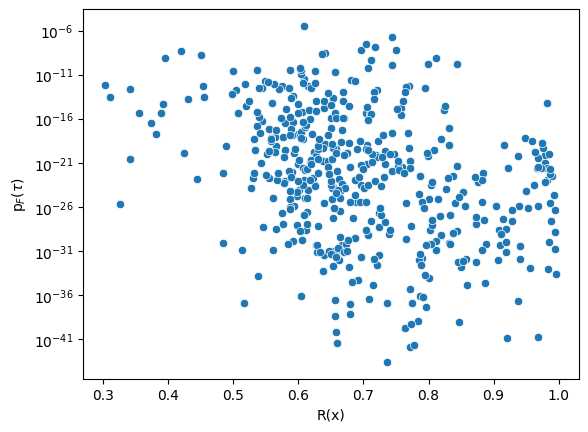

In [28]:
sns.scatterplot(valid_df, x="reward", y="traj_p_F")
plt.yscale("log")
plt.xlabel("R(x)")
plt.ylabel(r"p$_F(\tau)$")
plt.show()

Loss vs. reward R(x). High rewards should have a low loss.

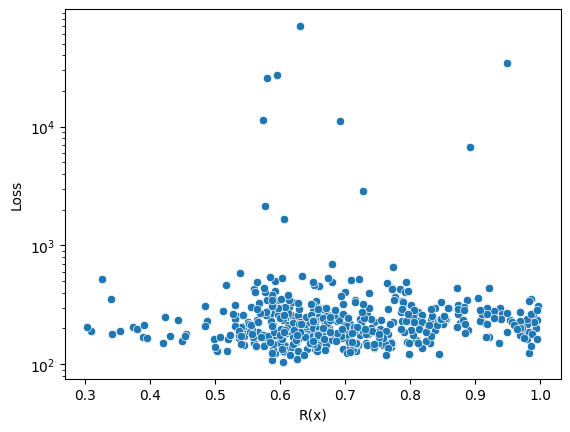

In [29]:
sns.scatterplot(valid_df, x="reward", y="loss")
plt.yscale("log")
plt.xlabel("R(x)")
plt.ylabel(r"Loss")
plt.show()

Loss vs. reward R(x). 

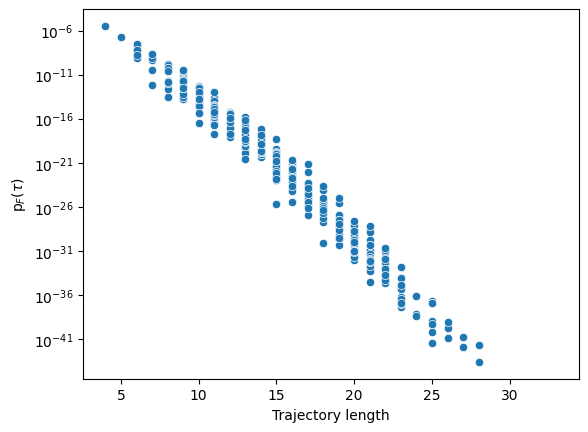

In [30]:
sns.scatterplot(valid_df, x="traj_lens", y="traj_p_F")
plt.yscale("log")
plt.xlabel("Trajectory length")
plt.ylabel(r"p$_F(\tau)$")
plt.show()

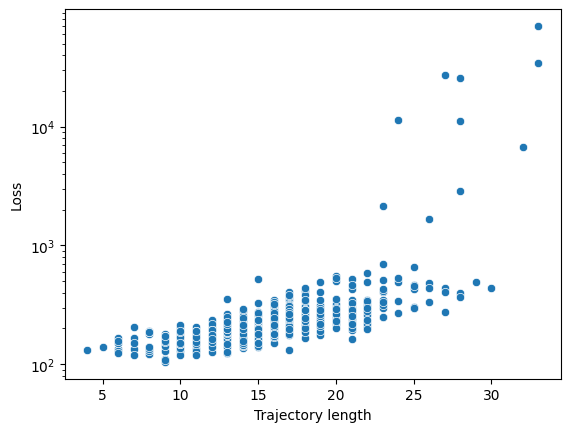

In [31]:
sns.scatterplot(valid_df, x="traj_lens", y="loss")
plt.yscale("log")
plt.xlabel("Trajectory length")
plt.ylabel(r"Loss")
plt.show()

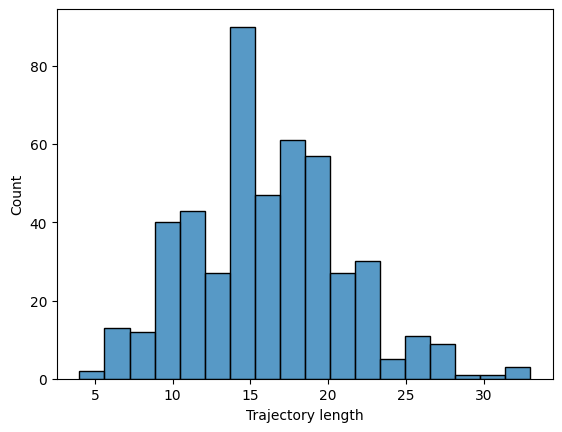

In [32]:
sns.histplot(data=valid_df, x="traj_lens")
plt.xlabel("Trajectory length")
plt.show()

## Analyze

### Training metrics

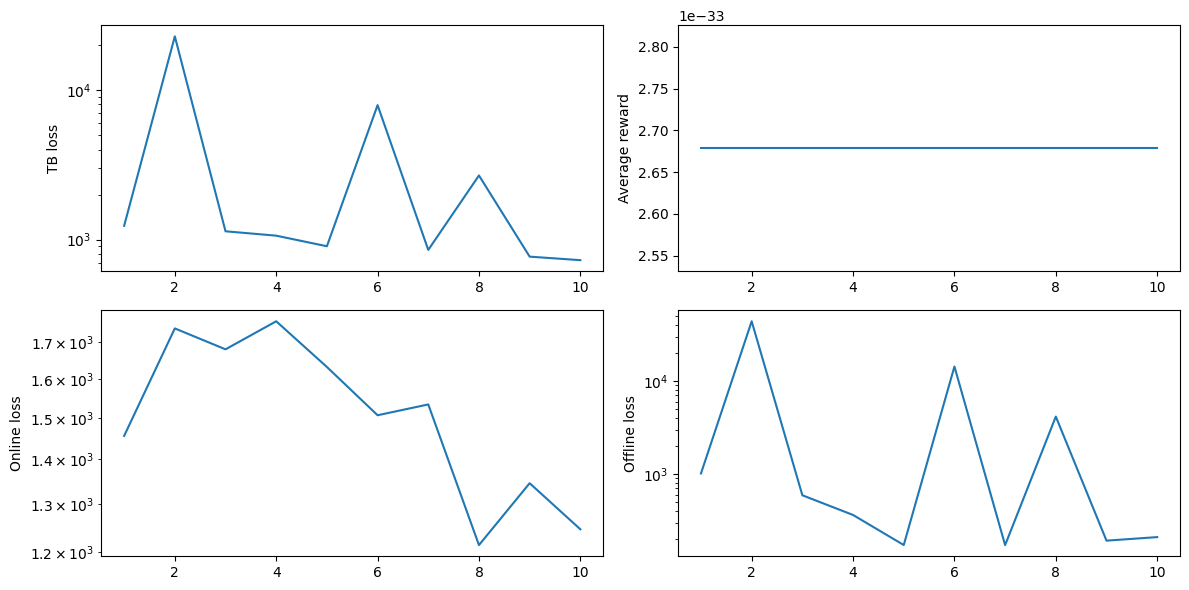

In [11]:
cfg = init_empty(Config())
cfg.log_dir = config.log_dir # Can be modified
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

x = [i+1 for i in range(len(ea.Scalars('train_loss')))]
f, ax = plt.subplots(2, 2, figsize=(4*3,6))
sns.lineplot(y=[i.value for i in ea.Scalars('train_loss')],x=x, ax=ax[0,0])
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('TB loss')
sns.lineplot(y=[i.value for i in ea.Scalars('train_sampled_reward_avg')],x=x, ax=ax[0,1])
ax[0,1].set_ylabel('Average reward')
sns.lineplot(y=[i.value for i in ea.Scalars('train_online_loss')],x=x, ax=ax[1,0])
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Online loss')
sns.lineplot(y=[i.value for i in ea.Scalars('train_offline_loss')],x=x, ax=ax[1,1])
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Offline loss')
plt.tight_layout()

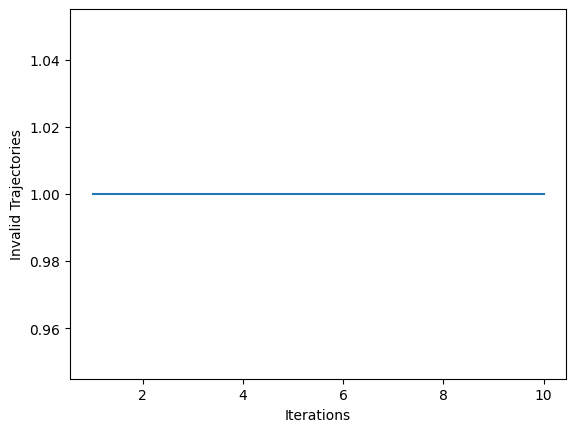

In [12]:
sns.lineplot(y=[i.value for i in ea.Scalars('train_invalid_trajectories')],x=x)
plt.ylabel("Invalid Trajectories")
plt.xlabel("Iterations")
plt.show()

### Molecule visualization

#### Generate New Molecules

In [13]:
def sample_molecules_from_model(gen_trainer, amont=25):
    # Generate molecules
    trajs = gen_trainer.algo.create_training_data_from_own_samples(gen_trainer.model, amont)
    objs = [gen_trainer.ctx.graph_to_obj(i['result']) for i in trajs]
    obj_props, is_valid = gen_trainer.task.compute_obj_properties(objs)
    cond_info = gen_trainer.task.sample_conditional_information(len(obj_props), 1)
    log_rewards = gen_trainer.task.cond_info_to_logreward(cond_info, obj_props)
    
    valid_idcs = torch.tensor([i for i in range(len(trajs)) if trajs[i].get("is_valid", True)]).long()    

    valid_idcs = valid_idcs[is_valid]
    all_fr = torch.zeros((len(trajs), obj_props.shape[1]))
    all_fr[valid_idcs] = obj_props
    rewards = all_fr.flatten()

    return objs, obj_props, is_valid, rewards, log_rewards

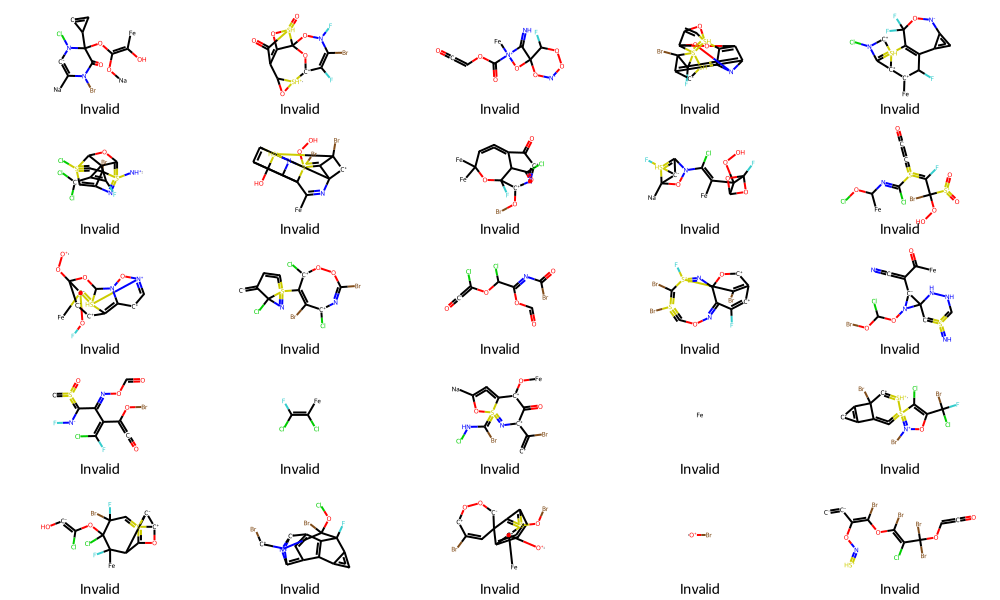

In [14]:
objs, obj_props, is_valid, rewards, log_rewards = sample_molecules_from_model(trainer, amont=25)
MolsToGridImage(objs, molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' if r != 0 else "Invalid" for r in rewards  ])

#### Analyse Training Molecules

In [15]:
log_dir = config.log_dir
conn = sqlite3.connect(f"{log_dir}/train/generated_objs_0.db")
training_df = pd.read_sql_query("SELECT * FROM results", conn)
training_df.head()

,smi,r,fr_0
0,,2.678637e-33,0.0
1,,2.678637e-33,0.0
2,,2.678637e-33,0.0
3,,2.678637e-33,0.0
4,,2.678637e-33,0.0


Top molcules

In [16]:
def get_n_top_molecules(n):
    top_rewards = training_df.sort_values(by='r', ascending=False).head(n)
    objs = [Chem.MolFromSmiles(smiles) for smiles in top_rewards["smi"]]
    rewards = top_rewards["r"]
    return objs, rewards

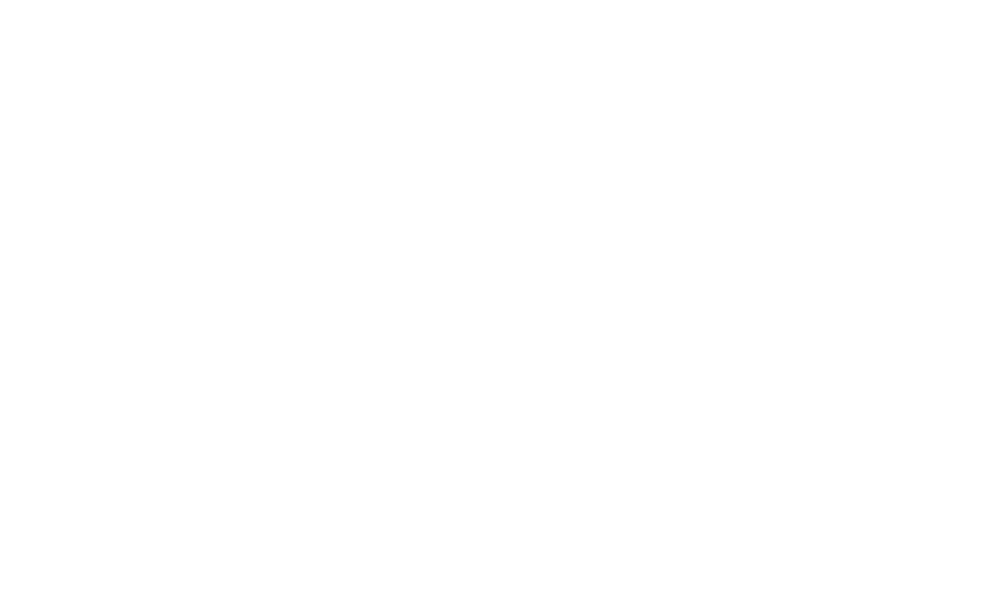

In [17]:
objs, rewards = get_n_top_molecules(25)
MolsToGridImage(objs, molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards])

Get molecules during last training episode

In [18]:
def get_last_molecules(cfg, df):
    n = cfg.algo.valid_num_from_policy
    objs = [Chem.MolFromSmiles(smiles) for smiles in df[-n:]["smi"]]
    rewards = df[-n:]["r"]
    return objs, rewards

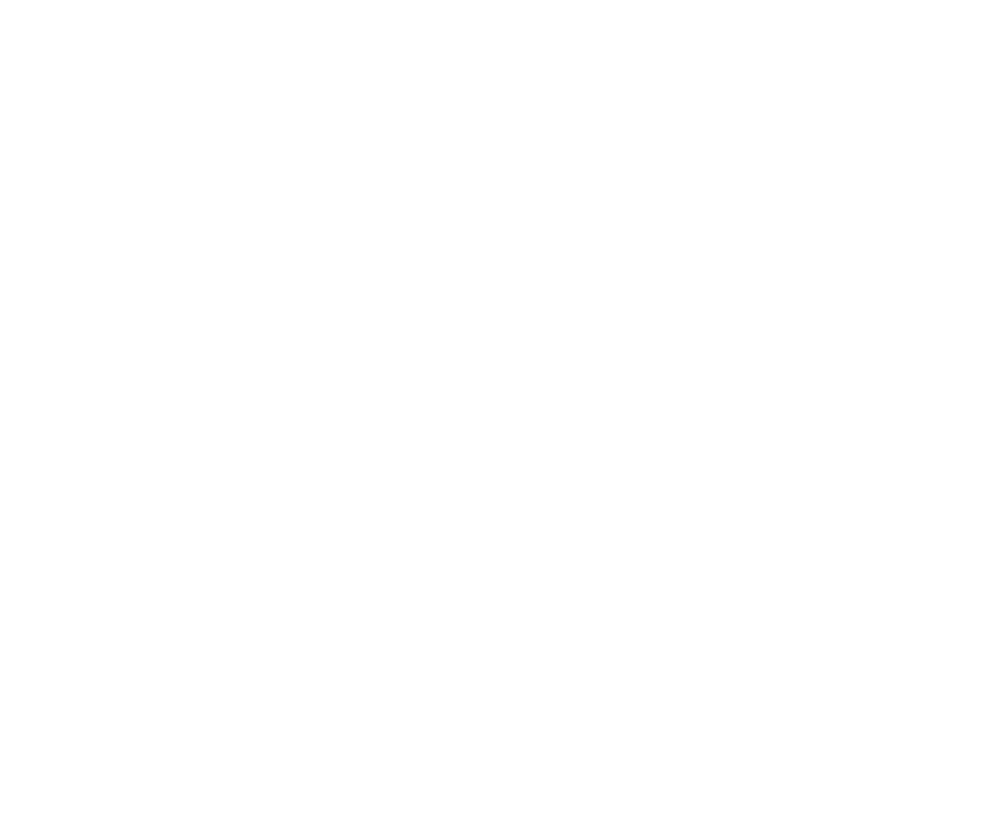

In [19]:
objs, rewards = get_last_molecules(config, training_df) 
MolsToGridImage(objs, molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards])

## Load

Run the [Root](#run-notebook-from-project-root) and [Import](#imports) sections. And some of the plotting functions.

### Initialize

Specify save directory. A copy of this directory will be created for the new trainer object. 

In [43]:
save_base="example copy 2"
save_index = 2
if save_index != 0:
    save_name = f"{save_base}_{save_index}"
else:
    save_name = save_base

In [44]:
original_log_dir = os.path.join(root_path, f"logs/{save_name}/")
original_log_dir

'c:\\Users\\paulj\\Desktop\\Master\\logs/example copy 2_2/'

### Loading functions

In [11]:
import re

def increment_name(name):
    # Regex to capture the base name and optional number suffix
    match = re.match(r"^(.*?)(?:_(\d+))?$", name)
    if not match:
        return name + "_1"
    
    base = match.group(1)
    num = match.group(2)
    
    if num is None:
        return f"{base}_1"
    else:
        return f"{base}_{int(num) + 1}"

def init_proceed_training(prev_log_dir):
    if prev_log_dir[-1] == "/":
        new_log_dir = increment_name(prev_log_dir[:-1])
    else:
        new_log_dir = increment_name(prev_log_dir)
    
    if not os.path.exists(new_log_dir):
        shutil.copytree(original_log_dir,new_log_dir)
    else:
        raise FileExistsError(f"Save directory {new_log_dir} already exists - Abort")
    return new_log_dir,prev_log_dir
    

In [20]:


def load_trainer_from_checkpoint(prev_log_dir: str, trainer_class: type, start_at_step:int=None, num_training_steps:int=None, id:int=0):
    
    log_dir, prev_log_dir = init_proceed_training(prev_log_dir)
    checkpoint_path = os.path.join(log_dir, "model_final_save.pt")
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    
    # Restore the config
    cfg = checkpoint["cfg"]
    cfg = OmegaConf.to_container(cfg, resolve=True)  
    cfg_obj = OmegaConf.structured(Config)             
    cfg_merged = OmegaConf.merge(cfg_obj, cfg)     
    cfg = OmegaConf.to_object(cfg_merged)  

    if log_dir != cfg.log_dir:
        cfg.log_dir = log_dir

    # Ensure the correct start step
    if start_at_step:
        cfg.start_at_step = start_at_step
    else:
        cfg.start_at_step = cfg.num_training_steps
    print(f"Start at step: {cfg.start_at_step}")

    # Ensure the correct start step
    if num_training_steps:
        cfg.num_training_steps = cfg.start_at_step+num_training_steps
    else:
        cfg.num_training_steps = cfg.start_at_step+cfg.num_training_steps


    # If log_dir exists and shouldn't be overwritten, disable deletion
    cfg.overwrite_existing_exp = True

    # Instantiate the trainer
    trainer = trainer_class(cfg)

    # Load model weights
    trainer.model.load_state_dict(checkpoint["models_state_dict"][0])
    if "sampling_model_state_dict" in checkpoint:
        trainer.sampling_model.load_state_dict(checkpoint["sampling_model_state_dict"][0])
    else:
        trainer.sampling_model.load_state_dict(checkpoint["models_state_dict"][0])
    trainer.model.eval()
    trainer.sampling_model.eval()

    trainer.model.to(trainer.device)
    trainer.sampling_model.to(trainer.device)


    return trainer, cfg, prev_log_dir


In [23]:

def continue_training(trainer,prev_log_dir):
    trainer.run()
    #with open(os.path.join(prev_log_dir, "train.log"), "r") as f_old, open(os.path.join(trainer.cfg.log_dir, "train.log"), "a") as f_new:
    save_run(trainer)

    gc.collect()
    # Read contents
    with open(os.path.join(prev_log_dir, "train.log"), "r", encoding="utf-8") as f_old:
        old_content = f_old.read()
    with open(os.path.join(trainer.cfg.log_dir, "train.log"), "r", encoding="utf-8") as f_new:
        new_content = f_new.read()

    #   Write new file with old content first
    with open(os.path.join(trainer.cfg.log_dir, "train.log"), "w", encoding="utf-8") as f_new:
        f_new.write(old_content)
        f_new.write(new_content)



In [14]:
def merge_event_scalars(log_dirs):
    merged_scalars = defaultdict(list)  # tag -> list of events (across all logs)

    for log_dir in log_dirs:
        ea = event_accumulator.EventAccumulator(log_dir)
        ea.Reload()

        # Get all scalar tags in this log directory
        tags = ea.Tags().get('scalars', [])

        for tag in tags:
            merged_scalars[tag].extend(ea.Scalars(tag))

    
    for tag, events in merged_scalars.items():
        merged_scalars[tag] = sorted(events, key=lambda e: e.step)
    return merged_scalars, merged_scalars[tag][-1].step

In [15]:
def find_immediate_subdirs_with_string(log_dir,substring):
    root_dir = os.path.dirname(log_dir.rstrip("/"))
    return [
        os.path.join(root_dir, d)
        for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d)) and substring in d
    ]


In [16]:
def get_training_df(log_dirs):
    training_df = pd.DataFrame()
    for l_dir in log_dirs:
        conn = sqlite3.connect(f"{l_dir}/train/generated_objs_0.db")
        new_training_df = pd.read_sql_query("SELECT * FROM results", conn)
        training_df = pd.concat([training_df, new_training_df], ignore_index=True)
    return training_df

### Initialize Trainer

In [45]:
log_dirs = find_immediate_subdirs_with_string(original_log_dir,save_base)
log_dirs

['c:\\Users\\paulj\\Desktop\\Master\\logs\\example copy 2',
 'c:\\Users\\paulj\\Desktop\\Master\\logs\\example copy 2_1',
 'c:\\Users\\paulj\\Desktop\\Master\\logs\\example copy 2_2']

In [46]:
_, start_at_step = merge_event_scalars(log_dirs)
start_at_step

14

In [47]:
gc.collect()
trainer, cfg, prev_log_dir = load_trainer_from_checkpoint(original_log_dir, ScentTrainer, start_at_step=start_at_step, num_training_steps=2)

Start at step: 14


Hyperparameters:

desc: noDesc
log_dir: c:\Users\paulj\Desktop\Master\logs/example copy 2_3
device: cpu
seed: 1
validate_every: 1000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 14
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 16
num_workers: 0
hostname: LAPTOP-JIE0TNQT
pickle_mp_messages: false
git_hash: 52c8ef4
overwrite_existing_exp: true
algo:
  method: TB
  num_from_policy: 32
  num_from_dataset: 32
  valid_num_from_policy: 32
  valid_num_from_dataset: 32
  max_len: 128
  max_nodes: 20
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.001
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9840271666819398
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: SubTB1
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normaliz

### Continue Training

In [48]:
continue_training(trainer,prev_log_dir)

26/05/2025 13:27:34 - INFO - logger - Starting training


26/05/2025 13:27:48 - INFO - logger - iteration 15 : offline_loss:716.99 online_loss:1085.91 reward_loss:0.00 invalid_trajectories:1.00 invalid_logprob:-60.80 invalid_losses:1085.90 backward_vs_unif:0.00 logZ:-9.84 loss:901.45 n_loss:0.00 tb_loss:901.45 batch_entropy:61.11 traj_lens:16.83 grad_norm:1027.27 grad_norm_clip:32.28 sampled_reward_avg:0.00 train_time:5.98 time_spent:13.46
26/05/2025 13:28:00 - INFO - logger - iteration 16 : offline_loss:270.04 online_loss:1106.03 reward_loss:0.00 invalid_trajectories:1.00 invalid_logprob:-48.14 invalid_losses:1106.02 backward_vs_unif:0.00 logZ:-10.77 loss:688.03 n_loss:0.00 tb_loss:688.03 batch_entropy:52.69 traj_lens:15.83 grad_norm:1399.01 grad_norm_clip:32.28 sampled_reward_avg:0.00 train_time:5.60 time_spent:12.07


### Validation

Ensure that the validation set is the same for reinitialized models (Should be the same due to seed).

In [ ]:
#np.array_equal(old_test_data,trainer.test_data.idcs), np.array_equal(old_training_data,trainer.training_data.idcs)
#old_test_data, old_training_data = trainer.test_data.idcs,trainer.training_data.idcs

(True, True)

#### Run Validation

In [57]:
batch_idx = trainer.cfg.num_training_steps % max(len(trainer.training_data),1)
epoch_idx = trainer.cfg.num_training_steps // max(len(trainer.training_data),1)
batch_idx,epoch_idx

(16, 0)

In [62]:
validation_config

{'desc': 'noDesc', 'log_dir': 'c:\\Users\\paulj\\Desktop\\Master\\logs/example copy 2__validation', 'device': 'cpu', 'seed': 1, 'validate_every': 1000, 'checkpoint_every': None, 'store_all_checkpoints': False, 'print_every': 1, 'start_at_step': 14, 'num_final_gen_steps': None, 'num_validation_gen_steps': 1, 'num_training_steps': 16, 'num_workers': 0, 'hostname': 'LAPTOP-JIE0TNQT', 'pickle_mp_messages': False, 'git_hash': '52c8ef4', 'overwrite_existing_exp': True, 'algo': {'method': 'TB', 'num_from_policy': 32, 'num_from_dataset': 32, 'valid_num_from_policy': 0, 'valid_num_from_dataset': 1, 'max_len': 128, 'max_nodes': 20, 'max_edges': 128, 'illegal_action_logreward': -75.0, 'train_random_action_prob': 0.001, 'train_det_after': None, 'valid_random_action_prob': 0.0, 'sampling_tau': 0.9840271666819398, 'tb': {'bootstrap_own_reward': False, 'epsilon': None, 'reward_loss_multiplier': 1.0, 'variant': <TBVariant.SubTB1: 1>, 'do_correct_idempotent': False, 'do_parameterize_p_b': False, 'do_pr

In [63]:
validation_config = copy.deepcopy(cfg)
validation_config.algo.valid_num_from_policy= 0
validation_config.algo.valid_num_from_dataset= 1
validation_config.log_dir = trainer.cfg.log_dir[:-1] + "_validation"
validation_trainer = ScentTrainer(validation_config, print_config=False)
validation_trainer.model = copy.deepcopy(trainer.model)
validation_trainer.sampling_model = copy.deepcopy(trainer.model)
validation_trainer.training_data = copy.deepcopy(trainer.training_data)
validation_trainer.test_data = copy.deepcopy(trainer.test_data)

In [64]:
n_drawn = validation_trainer.cfg.algo.valid_num_from_policy
n_from_dataset = validation_trainer.cfg.algo.valid_num_from_dataset
n_drawn,n_from_dataset

(0, 1)

In [65]:
valid_dl = validation_trainer.build_validation_data_loader()
df = trainer.test_data.df.iloc[validation_trainer.test_data.idcs]
#valid_df = pd.DataFrame()
rows = []



for batch, smiles in zip(valid_dl, df["nonStereoSMILES"]):
    info = validation_trainer.evaluate_batch(batch.to(validation_trainer.device), epoch_idx, batch_idx)
    batch_idx_ = torch.arange(n_from_dataset, device=validation_trainer.device).repeat_interleave(batch.traj_lens)
    cond_info = getattr(batch, "cond_info", None)
    batched_cond_info = cond_info[batch_idx_] if cond_info is not None else None
    fwd_cat, per_graph_out = validation_trainer.model(batch, batched_cond_info)
    log_pF = fwd_cat.log_prob(batch.actions)
    traj_log_p_F = scatter(log_pF, batch_idx_, dim=0, dim_size=n_from_dataset, reduce="sum")
    log_p_B = batch.log_p_B
    traj_log_p_B = scatter(log_p_B, batch_idx_, dim=0, dim_size=n_from_dataset, reduce="sum")
    log_rewards = batch.log_rewards

    row = {
        'SMILES': smiles,
        'traj_p_F': traj_log_p_F.exp().item(),  
        'traj_p_B': traj_log_p_B.exp().item(),
        'reward': log_rewards.exp().item()
    }
    row = { **row, **info}
    rows.append(row)
    
    print(f"{smiles:<40} traj_p_F:{traj_log_p_F.exp().item():.5f} traj_p_B:{traj_log_p_B.exp().item():.5f} reward:{log_rewards.exp().item():.2f}" + " ".join(f"{k}:{v:.2f}" for k, v in info.items()))
    gc.collect()
valid_df = pd.DataFrame(rows)

CCCCCC(=O)OCCc1ccccc1                    traj_p_F:0.00000 traj_p_B:0.00000 reward:0.79offline_loss:387.35 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-11.66 loss:387.35 n_loss:0.00 tb_loss:387.35 batch_entropy:77.66 traj_lens:22.00 eval_time:0.12
CC1=CCC(=C(C)C)CC1                       traj_p_F:0.00000 traj_p_B:0.00000 reward:0.69offline_loss:196.06 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-11.66 loss:196.06 n_loss:0.00 tb_loss:196.06 batch_entropy:45.27 traj_lens:14.00 eval_time:0.06
CC1=C(O)C(=O)C(C)C1C                     traj_p_F:0.00000 traj_p_B:0.00000 reward:0.83offline_loss:197.28 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-11.66 loss:197.28 n_loss:0.00 tb_loss:197.28 batch_entropy:46.67 traj_lens:14.00 eval_time:0.06
CCCCCCC

In [66]:
valid_df.to_csv(os.path.join(trainer.cfg.log_dir, "example_validation.csv"),index=None)
valid_df.head()


,SMILES,traj_p_F,traj_p_B,reward,offline_loss,online_loss,reward_loss,invalid_trajectories,invalid_logprob,invalid_losses,backward_vs_unif,logZ,loss,n_loss,tb_loss,batch_entropy,traj_lens,eval_time
0,CCCCCC(=O)OCCc1ccccc1,1.876313e-34,6.056464e-12,0.789376,387.351868,0,0,0,0.0,0.0,0.0,-11.663285,387.351868,0.0,387.351868,77.658585,22.0,0.122832
1,CC1=CCC(=C(C)C)CC1,2.184770e-20,2.286234e-08,0.689498,196.061996,0,0,0,0.0,0.0,0.0,-11.663285,196.061996,0.0,196.061996,45.270191,14.0,0.061981
2,CC1=C(O)C(=O)C(C)C1C,5.373099e-21,7.381416e-09,0.830900,197.279282,0,0,0,0.0,0.0,0.0,-11.663285,197.279282,0.0,197.279282,46.672882,14.0,0.061487
3,CCCCCCCCCCCC(OC)OC,1.204458e-26,2.679190e-06,0.597757,404.242432,0,0,0,0.0,0.0,0.0,-11.663285,404.242432,0.0,404.242432,59.681183,17.0,0.063148
4,N#CC=Cc1ccccc1,1.784485e-27,5.295985e-10,0.904247,306.915192,0,0,0,0.0,0.0,0.0,-11.663285,306.915192,0.0,306.915192,61.590668,17.0,0.058249


### Training Metrics

In [27]:
log_dirs = find_immediate_subdirs_with_string(original_log_dir,save_base)
log_dirs

['c:\\Users\\paulj\\Desktop\\Master\\logs\\example copy 2',
 'c:\\Users\\paulj\\Desktop\\Master\\logs\\example copy 2_1',
 'c:\\Users\\paulj\\Desktop\\Master\\logs\\example copy 2_2']

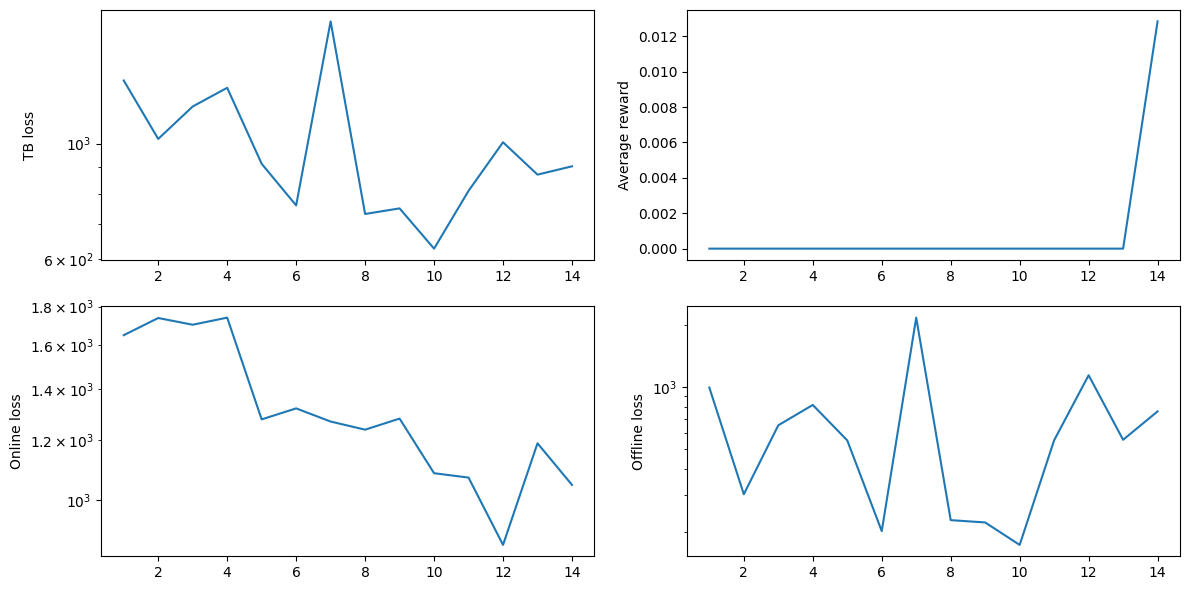

In [29]:

event_scalars, _ = merge_event_scalars(log_dirs)
x = [i+1 for i in range(len(event_scalars['train_loss']))]
f, ax = plt.subplots(2, 2, figsize=(4*3,6))
sns.lineplot(y=[ e.value for e in event_scalars['train_loss']],x=x, ax=ax[0,0])
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('TB loss')
sns.lineplot(y=[ e.value for e in event_scalars['train_sampled_reward_avg']],x=x, ax=ax[0,1])
ax[0,1].set_ylabel('Average reward')
sns.lineplot(y=[ e.value for e in event_scalars['train_online_loss']],x=x, ax=ax[1,0])
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Online loss')
sns.lineplot(y=[ e.value for e in event_scalars['train_offline_loss']],x=x, ax=ax[1,1])
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Offline loss')
plt.tight_layout()

### Generate Molecules

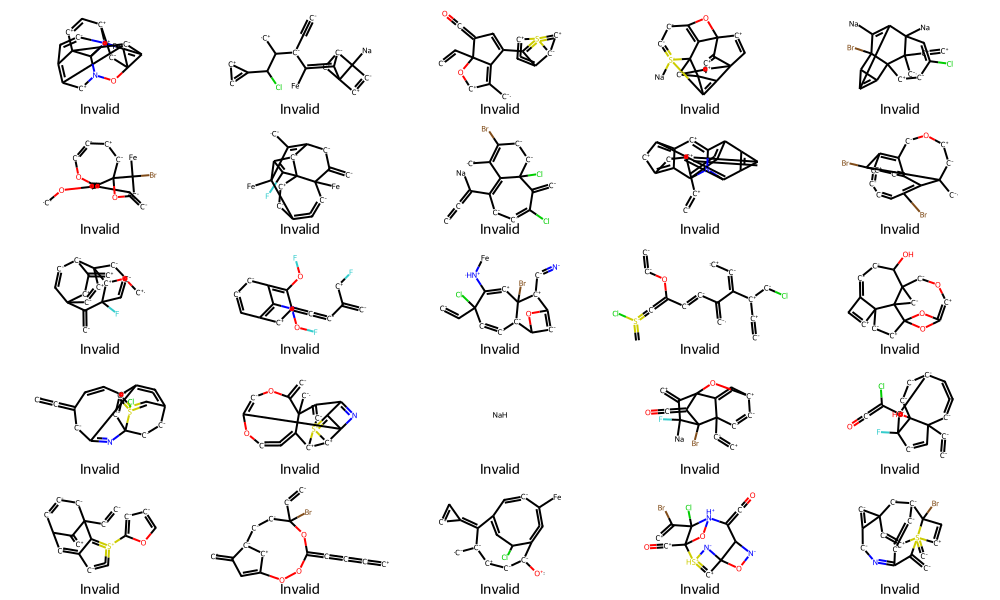

In [30]:
objs, obj_props, is_valid, rewards, log_rewards = sample_molecules_from_model(trainer, amont=25)
MolsToGridImage(objs, molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' if r != 0 else "Invalid" for r in rewards  ])

### Analyse Training Molecules

In [31]:
training_df = get_training_df(log_dirs)

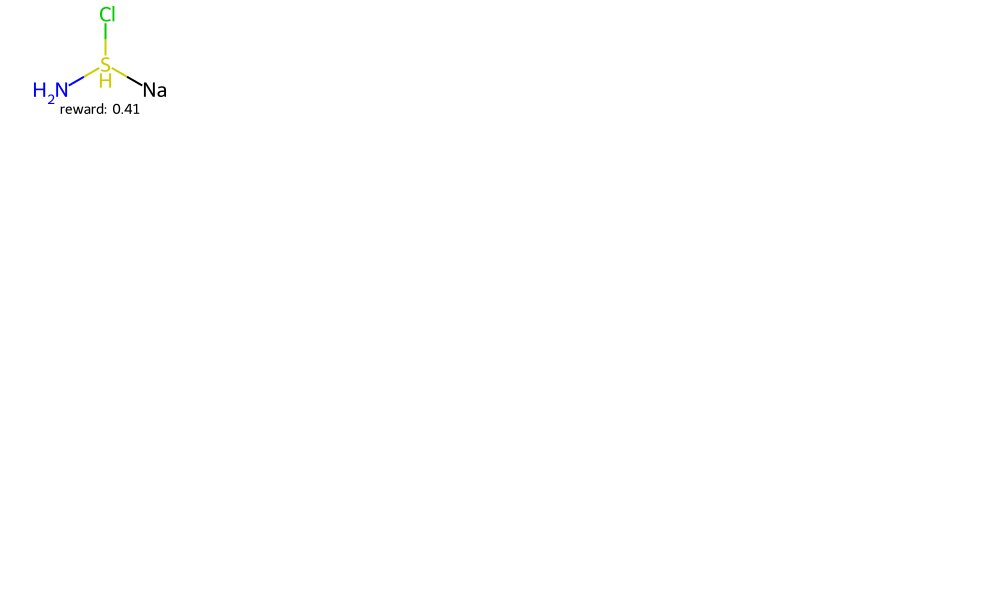

In [32]:
objs, rewards = get_n_top_molecules(25)
MolsToGridImage(objs, molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards])

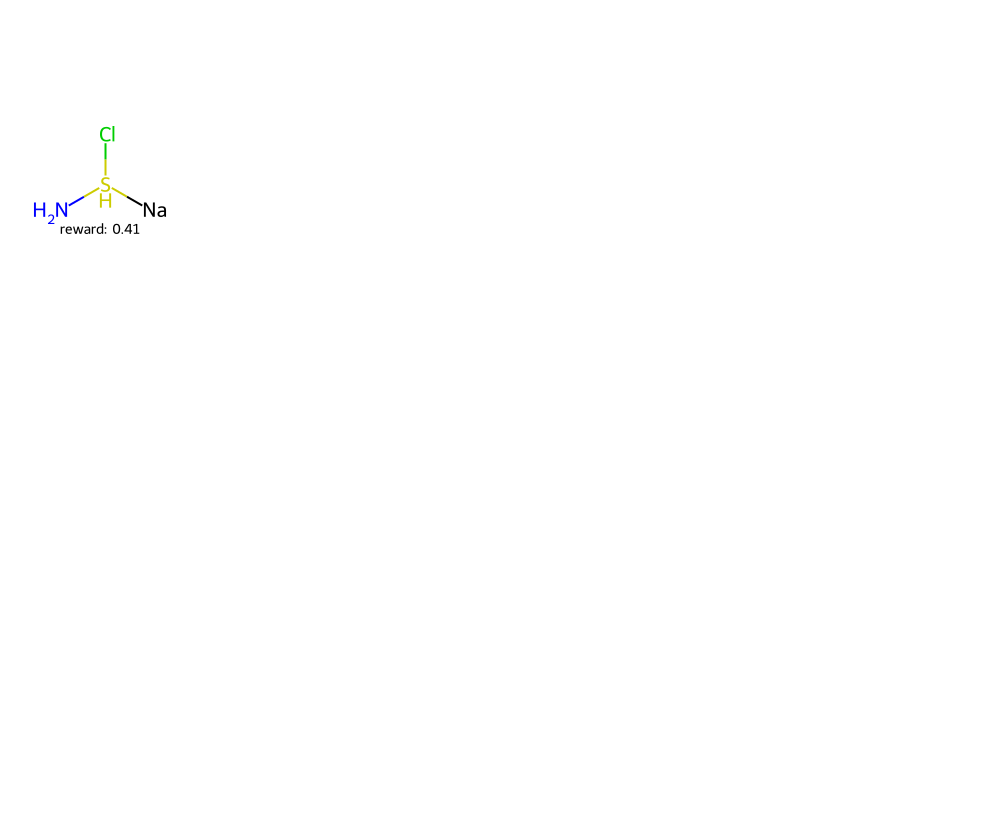

In [34]:
objs, rewards = get_last_molecules(trainer.cfg, training_df) 
MolsToGridImage(objs, molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards])

### Old code

In [ ]:
#log_dir = os.path.join(root_path, "logs/example copy 2/")
# Model class must be defined somewhere
#log_dir = os.path.join(root_path, "logs/example copy/")
#state = torch.load(os.path.join(log_dir, "model_final_save.pt"), weights_only=False)
#config = state["cfg"]
#env_ctx = state["env_ctx"]
#model = gflownet.models.graph_transformer.GraphTransformerGFN(state["env_ctx"],state["cfg"])
#model.load_state_dict(state["models_state_dict"][0])
#model.eval()

In [ ]:
#retrainer = ScentTrainer(config, print_config=True)

In [ ]:
#algo = TrajectoryBalance(GraphBuildingEnv(),state["env_ctx"],state["cfg"])

In [ ]:
#ctx = MolBuildingEnvContext(
            #['Br', 'C', 'Cl', 'F', 'Fe', 'N', 'Na', 'O', 'S'],
            #chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
           # expl_H_range=[0,1],
            #num_cond_dim=1,
            #max_nodes=20,
        #)

In [ ]:
# Generate molecules
#trajs = algo.create_training_data_from_own_samples(model, 25)
#objs = [ctx.graph_to_obj(i['result']) for i in trajs]
M#olsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120))